In [1]:
"""
TODO:
- [x] Fix train/valid generator
- [x] Add image augmentation methods & demo
- [] Plot train/val loss?
- [] Collect more data
"""
print(".")

.


Image Processing Code Segment
---

Describe different functions...

In [2]:
import os, sys, glob, time

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 160, 320, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
IMAGE_COLS = ('center', 'left', 'right')
STEER_COLS = ('steering')


def load_image(data_dir, image_file):
    """Load RGB images from a file"""
    
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))


def resize(image):
    """Resize image to determined sizes"""
    
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)


def crop(image):
    """Crop the image (removing the sky at the top and the car front at the bottom)
    
    Credit: https://github.com/naokishibuya/car-behavioral-cloning
    """
    
    return image[60:-25, :, :] # remove the sky and the car front


def rgb2yuv(image):
    """Convert the image from RGB to YUV to support the NVIDIA model.
    
    Credit: https://github.com/naokishibuya/car-behavioral-cloning
    """
    
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)


def random_flip(image, steer_angle, **config):
    """
    Randomly flip the image left <-> right, and adjust the steering angle.
    Credit: https://github.com/naokishibuya/car-behavioral-cloning
    """
    
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steer_angle = -steer_angle
        
    return image, steer_angle


def random_translate(image, steer_angle, **config):
    """
    Randomly shift the image vertically and horizontally (translation).
    Credit: https://github.com/naokishibuya/car-behavioral-cloning
    """
    
    range_x, range_y = config.get('range_x', 100), config.get('range_y', 10)
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steer_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    
    return image, steer_angle


def random_shadow(image, **config):
    """Generates and adds random shadow
    
    Credit: https://github.com/naokishibuya/car-behavioral-cloning
    """
    
    # (x1, y1) and (x2, y2) forms a line
    # xm, ym gives all the locations of the image
    x1, y1 = IMAGE_WIDTH * np.random.rand(), 0
    x2, y2 = IMAGE_WIDTH * np.random.rand(), IMAGE_HEIGHT
    xm, ym = np.mgrid[0:IMAGE_HEIGHT, 0:IMAGE_WIDTH]

    # Mathematically speaking, we want to set 1 below the line and zero otherwise
    # Our coordinate is up side down.  So, the above the line: 
    # (ym-y1)/(xm-x1) > (y2-y1)/(x2-x1)
    # as x2 == x1 causes zero-division problem, we'll write it in the below form:
    # (ym-y1)*(x2-x1) - (y2-y1)*(xm-x1) > 0
    mask = np.zeros_like(image[:, :, 1])
    mask[(ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0] = 1

    # Choose which side should have shadow and adjust saturation
    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    # Adjust Saturation in HLS(Hue, Light, Saturation)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)


def random_brightness(image, **config):
    """Randomly adjust brightness of the image.
    
    Credit: https://github.com/naokishibuya/car-behavioral-cloning
    """
    
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:, :, 2] =  hsv[:, :, 2] * ratio # Increase V for bright, only 50% at the time
    
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)


def process_image(image):
    """Create standard image preprocessing pipeline, with option to augment"""
    
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    
    return image


def choose_adjust(data_dir, data_row, steer_angle, **config):
    """Choose randomly out of center/left/right and adjust steer
    
    Left = positive steer
    Right = negative steer
    """
    
    choice = np.random.choice(3)
    if choice == 0: # Center
        return load_image(data_dir, data_row[IMAGE_COLS[choice]]), steer_angle
    elif choice == 1: # Left, steer more left
        return load_image(data_dir, data_row[IMAGE_COLS[choice]]), steer_angle + config.get('steer_corr', 0.2)
    else: # Right, steer more right
        return load_image(data_dir, data_row[IMAGE_COLS[choice]]), steer_angle - config.get('steer_corr', 0.2)


def augment_pipeline(data_dir, data_row, steer_angle, **config):
    """Create random image augmentation for training"""
    
    image, steer_angle = choose_adjust(data_dir, data_row, steer_angle, **config)
    image, steer_angle = random_flip(image, steer_angle, **config)
    image, steer_angle = random_translate(image, steer_angle, **config)
    image = random_shadow(image, **config)
    image = random_brightness(image, **config)
    image = process_image(image) # Standard
    
    return image, steer_angle


def batch_generator(data_dir, image_df, steering_df, batch_size=64, is_training=True, **augment_config):
    """Generate batch to load. 
    
    A generator is like a coroutine, a process that can run separately from another main routine. More memory efficient
    
    Args:
        data_dir
        image_df: (n, 3) dataframe of ('center', 'left', 'right')
        steering_df: (n, 1) dataframe of ('steering)
        batch_size
        is_training
    
    Returns:
        generator
    """
    
    while 1:
        feats = np.zeros((batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
        responses = np.zeros((batch_size))
        
        batch_image = image_df.sample(batch_size)
        batch_steer = steering_df[batch_image.index].reset_index(drop=True)
        batch_image.reset_index(inplace=True, drop=True)
        
        for i, row in batch_image.iterrows():
            if is_training:
                feats[i, :, :, :], responses[i] = augment_pipeline(data_dir, row, batch_steer[i], **augment_config)
            else:
                feats[i, :, :, :] = process_image(load_image(data_dir, row[IMAGE_COLS[0]]))
                responses[i] = float(batch_steer[i])

        yield feats, responses

In [3]:
data_dir = 'data/sample_data'
log_path = os.path.join(data_dir, 'driving_log.csv')

In [4]:
log_df = pd.read_csv(log_path)
print(len(log_df))

8036


Visualization
---
Describe different augmentation effects

Steering = -0.135712, Throttle = 0.9855325999999999, Brake = 0.0, Speed = 30.18505 


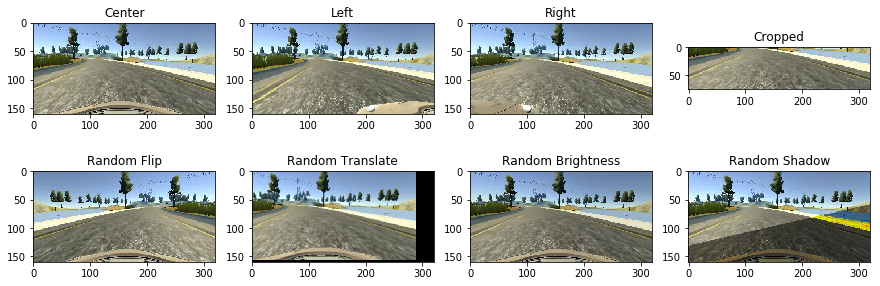

Steering = 0.0, Throttle = 0.9855325999999999, Brake = 0.0, Speed = 30.18665 


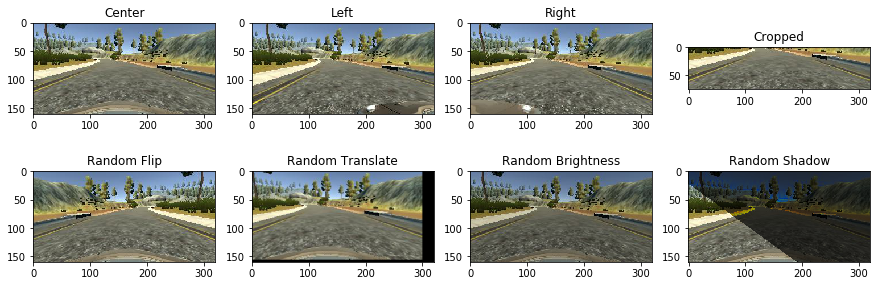

Steering = -0.23065560000000002, Throttle = 0.9855325999999999, Brake = 0.0, Speed = 30.18238 


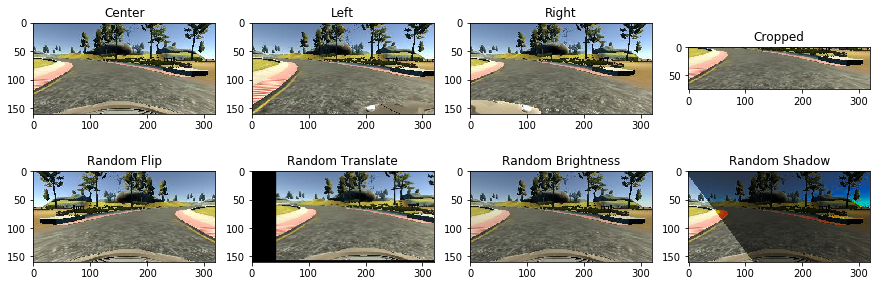

In [5]:
# Visualization
for _, row in log_df.sample(3).iterrows():
    print("Steering = {0[0]}, Throttle = {0[1]}, Brake = {0[2]}, Speed = {0[3]} ".format(row[3:]))
    center_image = load_image(data_dir, row['center'])
    left_image = load_image(data_dir, row['left'])
    right_image = load_image(data_dir, row['right'])
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 5))
    ax[0, 0].imshow(center_image)
    ax[0, 0].set_title('Center')
    ax[0, 1].imshow(left_image)
    ax[0, 1].set_title('Left')
    ax[0, 2].imshow(right_image)
    ax[0, 2].set_title('Right')
    ax[0, 3].imshow(crop(center_image))
    ax[0, 3].set_title('Cropped')
    ax[1, 0].imshow(random_flip(center_image, 0.0)[0])
    ax[1, 0].set_title('Random Flip')
    ax[1, 1].imshow(random_translate(center_image, 0.0)[0])
    ax[1, 1].set_title('Random Translate')
    ax[1, 2].imshow(random_brightness(center_image))
    ax[1, 2].set_title('Random Brightness')
    ax[1, 3].imshow(random_shadow(center_image))
    ax[1, 3].set_title('Random Shadow')
    plt.show()

Generator Usage
---
Describe the `batch_generator()` method. How is it more memory efficient

In [6]:
sample_gen = batch_generator(data_dir, log_df.loc[:, IMAGE_COLS], log_df.loc[:, STEER_COLS])

for _ in range(5):
    X, y = next(sample_gen)
    print(X.shape, y.shape)

(64, 160, 320, 3) (64,)
(64, 160, 320, 3) (64,)
(64, 160, 320, 3) (64,)
(64, 160, 320, 3) (64,)
(64, 160, 320, 3) (64,)


In [7]:
"""
Goal: use images as features to predict steering angles

Adjust brake and speed manually?

"""

'\nGoal: use images as features to predict steering angles\n\nAdjust brake and speed manually?\n\n'

Model Code Segment
---

Describe the NVIDIA structure.

Add Karparthy model. Valid = padding. Same = not pad

$$\frac{H/W - K + 2P}{S} + 1$$

In [8]:
from keras.models import Sequential # Import model class
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten # Import layers
from keras.optimizers import Adam # Import optimizer
from keras.callbacks import ModelCheckpoint # Import checkpoint

# Starting shape: (_, 160, 320, 3)
# Neuron layers sequence: (3, 24, 36, 48, 64)

model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1.0, input_shape=INPUT_SHAPE, name='Normalization')) # Standardize, no need for sklearn Standardizer?
model.add(Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2), activation='relu', name='Conv_L1')) 
model.add(Conv2D(filters=36, kernel_size=(5, 5), strides=(2, 2), activation='relu', name='Conv_L2'))
model.add(Conv2D(filters=48, kernel_size=(5, 5), strides=(2, 2), activation='relu', name='Conv_L3'))
model.add(Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), activation='relu', name='Conv_L4')) # Reduce stride to have more fine-grain detail
model.add(Dropout(rate=0.5, name='Dropout_L1'))
model.add(Flatten(name='Flatten')) # Fully-connected layers
model.add(Dense(units=100, activation='relu', name='Dense_L1'))
model.add(Dense(units=50, activation='relu', name='Dense_L2'))
model.add(Dense(units=10, activation='relu', name='Dense_L3'))
model.add(Dense(units=1, name='Dense_L4'))

print(model.summary())

/home/toanlm/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normalization (Lambda)       (None, 160, 320, 3)       0         
_________________________________________________________________
Conv_L1 (Conv2D)             (None, 78, 158, 24)       1824      
_________________________________________________________________
Conv_L2 (Conv2D)             (None, 37, 77, 36)        21636     
_________________________________________________________________
Conv_L3 (Conv2D)             (None, 17, 37, 48)        43248     
_________________________________________________________________
Conv_L4 (Conv2D)             (None, 13, 33, 64)        76864     
_________________________________________________________________
Dropout_L1 (Dropout)         (None, 13, 33, 64)        0         
_________________________________________________________________
Flatten (Flatten)            (None, 27456)             0         
__________

Training Operations Code Segment
---

Sequence:
- Checkpoint
- Compile. MSE because we optimizer a continuous variable. Cross-entropy if we optimize classification
- Fit_generator

```python
# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# For a binary classification problem
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# For a mean squared error regression problem
model.compile(optimizer='rmsprop',
              loss='mse')

# For custom metrics
import keras.backend as K

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', mean_pred])
```

In [9]:
def train(model, optimizer, train_gen, val_gen, num_epoch=1, storage_path='models', verbose=True, **config):
    """Perform training operations given defined model"""
    
    if not os.path.exists(storage_path):
        os.makedirs(storage_path)
        
    # Checkpoint
    checkpoint = ModelCheckpoint(os.path.join(storage_path, '%s_{epoch:03d}.h5' %config.get('model_name', str(time.time()))), monitor='val_loss',
                                 save_best_only=True, 
                                 verbose=int(verbose), mode='auto') # Auto infer min_loss or max_acc of val set
    
    if optimizer is None:
        model.compile(optimizer='adagrad', loss='mse')
    else:
        model.compile(optimizer, loss='mse')
    
    history = model.fit_generator(train_gen, steps_per_epoch=config.get('train_steps', 50), epochs=num_epoch,
                        validation_data=val_gen, validation_steps=config.get('val_steps', 10),
                        callbacks=[checkpoint], max_q_size=config.get('max_queue_size', 10),
                        verbose=int(verbose),
                        workers=config.get('workers', 1), use_multiprocessing=config.get('multi_processing', False))
    
    return history

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(log_df.loc[:, IMAGE_COLS], log_df.loc[:, STEER_COLS])
num_train = len(X_train)
num_valid = len(X_valid)

batch_size = 64
config = {'correction': 0.3, 'model_name': '0929_after_augment',
          'train_steps': num_train // batch_size, 'val_steps': num_valid // batch_size}

train_gen = batch_generator(data_dir, X_train, y_train, batch_size=batch_size, is_training=True, **config)
valid_gen = batch_generator(data_dir, X_valid, y_valid, batch_size=batch_size, is_training=False, **config)

In [14]:
train(model, Adam(lr=0.001, decay=0.01), train_gen, valid_gen, num_epoch=5, **config)

/home/toanlm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=94, epochs=5, validation_data=<generator..., validation_steps=31, callbacks=[<keras.ca..., verbose=1, workers=1, use_multiprocessing=False, max_queue_size=10)`


Epoch 1/5
94/94 [==============================] - 120s 1s/step - loss: 0.0414 - val_loss: 0.0120

Epoch 00001: val_loss improved from inf to 0.01200, saving model to models/0929_after_augment_001.h5
Epoch 2/5
94/94 [==============================] - 120s 1s/step - loss: 0.0286 - val_loss: 0.0135

Epoch 00002: val_loss did not improve
Epoch 3/5
94/94 [==============================] - 119s 1s/step - loss: 0.0262 - val_loss: 0.0147

Epoch 00003: val_loss did not improve
Epoch 4/5
94/94 [==============================] - 119s 1s/step - loss: 0.0231 - val_loss: 0.0131

Epoch 00004: val_loss did not improve
Epoch 5/5
94/94 [==============================] - 119s 1s/step - loss: 0.0219 - val_loss: 0.0163

Epoch 00005: val_loss did not improve


In [ ]:
# Credit: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()